Let's train the models to classify ecg records. The ecg data from the previous steps is ready and should be divided into:
- training dataset (for model training - to update the weights)
- validation dataset (to monitor the validation loss and metrics during training)
- training dataset (for model evaluation after training - this data is never seen by model)

In case of large datasets, it's common to split it in the ratio of
+ 90% for training data
+ 5% for validation data
+ 5% for test data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import random

def plot_class_samples(label, x_train, y_train, x_valid, y_valid) :
    integer_train_labels = np.argmax(y_train, axis=1)
    integer_val_labels = np.argmax(y_valid, axis=1)

    if label > max(integer_val_labels) or label < 1:
        raise ValueError(f"The label {label} is not in [{min(integer_val_labels)}, {max(integer_val_labels)}]")

    class_indices = [i for i, e in enumerate(integer_train_labels) if e == label]
    plot_curves(f"Training samples of the class {label}:", x_train[class_indices])

    class_indices = [i for i, e in enumerate(integer_val_labels) if e == label]
    plot_curves(f"Validation samples of the class {label}:", x_valid[class_indices])

def plot_curves(header, curves) :
    print(header)
    for curve in curves : plt.plot(curve)
    plt.show()


In [2]:
import matplotlib.pyplot as plt

def plot_acc_loss(history) :
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [3]:
import random as rd

def evaluate_model(model, x_test, y_test) :
    samples_count = 15
    
    print("Evaluate on test data")
    test_metrics = model.evaluate(x_test, y_test)
    print("test loss, test acc:", test_metrics)
    
    test_indices = rd.sample(range(1, len(y_test)), samples_count)
    predictions = model.predict(x_test[test_indices])

    print(f"Actual labels:\t\t{np.argmax(y_test[test_indices], axis=1)}")
    print(f"Predicted labels:\t{np.argmax(predictions, axis=1)}")

Load datasets and display some examples of it.

Training samples of the class 325:


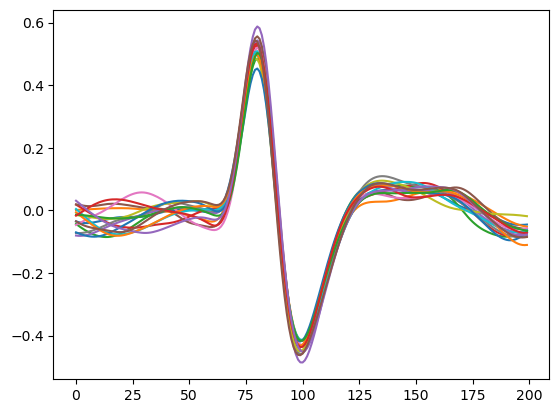

Validation samples of the class 325:


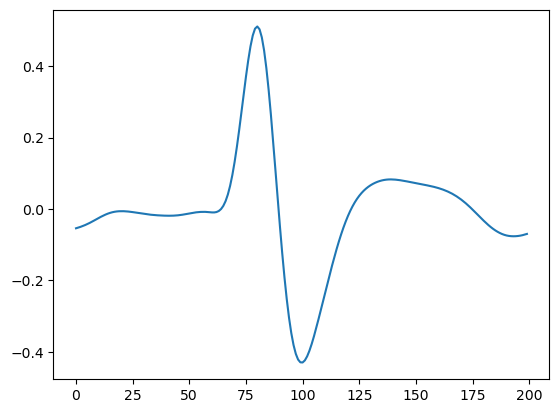

In [4]:
from data_processing.TrainTestSplitter import TrainTestSplitter

numclasses = 500 # take 500 classes from 827
samples = 18
processed_data_file = f"data/processed_ptb_xl_data_{samples}.pkl"
input_shape = (200, 1)

trainingPtbXl = TrainTestSplitter(
    pkl_file=processed_data_file,
    samples=samples,
    numclasses=numclasses)

x_train, x_test, x_valid, y_train, y_test, y_valid = trainingPtbXl.get_training_data()

plot_class_samples(random.randint(1, numclasses), x_train, y_train, x_valid, y_valid)

Leverage GPU-support before training the CNN-model to increase performance.

In [5]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 1, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 1, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 1, 120)  7800        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 1, 120)  480         conv2d[0][0]                     
______________________________________________________________________________________________

2000/2000 [==============================] - 110s 55ms/step - loss: 5.7931 - accuracy: 0.0064 - val_loss: 15.0149 - val_accuracy: 0.0040
Epoch 3/100
2000/2000 [==============================] - 108s 54ms/step - loss: 4.9438 - accuracy: 0.0468 - val_loss: 7.8183 - val_accuracy: 0.0200
Epoch 4/100
2000/2000 [==============================] - 109s 55ms/step - loss: 3.9733 - accuracy: 0.1380 - val_loss: 4.7081 - val_accuracy: 0.0880
Epoch 5/100
2000/2000 [==============================] - 109s 54ms/step - loss: 3.2449 - accuracy: 0.2451 - val_loss: 3.5653 - val_accuracy: 0.1780
Epoch 6/100
2000/2000 [==============================] - 89s 45ms/step - loss: 2.6903 - accuracy: 0.3500 - val_loss: 6.1379 - val_accuracy: 0.0900
Epoch 7/100
2000/2000 [==============================] - 62s 31ms/step - loss: 2.2630 - accuracy: 0.4376 - val_loss: 4.1516 - val_accuracy: 0.2060
Epoch 8/100
2000/2000 [==============================] - 62s 31ms/step - loss: 1.9420 - accuracy: 0.4986 - val_loss: 3.7274 -

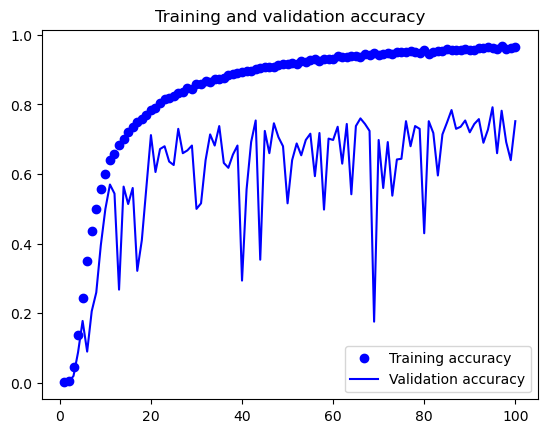

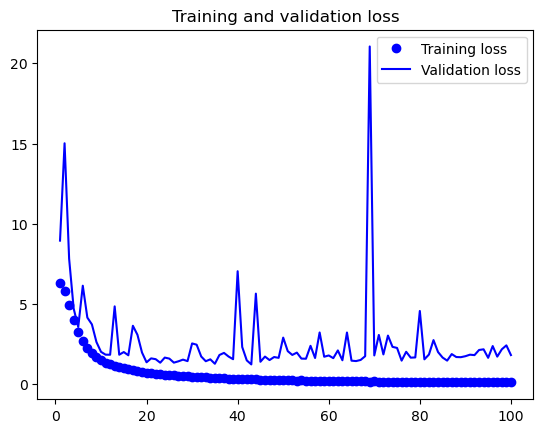

Evaluate on test data
16/16 [==============================] - 6s 151ms/step - loss: 1.5881 - accuracy: 0.7520
test loss, test acc: [1.5881495475769043, 0.7519999742507935]
Actual labels:		[  5 348 107  31  52 223 239 224 272  43  93 106 323 480 318]
Predicted labels:	[  5 348 107 185 431 223  96 224 272  43 235 106 305 480 318]


In [6]:
from os import path as Path
from tensorflow.keras.models import load_model
from models.ResNet1d import *

model_file = "1d_trained_resnet_ptbxl.keras"
input_shape = (200, 1)

if Path.exists(model_file) :
    model = load_model(model_file)
else :
    model, history = fit_resnet_model(x_train, y_train,
                                      x_valid, y_valid,
                                      numclasses, input_shape, model_file)
    plot_acc_loss(history)

evaluate_model(model, get_resnet_input(x_test), y_test)